<a href="https://colab.research.google.com/github/novay/amikom/blob/main/colab_webcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Webcam di Google Colab**

Keypoints:
- Komputer Vision adalah cabang ilmu komputer yang berfokus pada pemahaman dan analisis visual dari gambar dan video.
- Google Colab adalah platform yang menyediakan lingkungan pengembangan Python berbasis cloud.

Meskipun Google Colab memiliki banyak fitur yang berguna, namun tidak memiliki dukungan bawaan untuk menggunakan webcam. Namun, kita dapat menggunakan HTML dan JavaScript untuk mengatasi masalah ini. Di file notebook ini, saya akan coba mengimplementasikan OpenCV's Haar Cascade menggunakan webcam di Google Colab.

### **1. Persiapan**

Sebelum memulai, kita perlu menyiapkan pustaka yang akan digunakan :

In [25]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

Selanjutnya kita perlu membuat beberapa fungsi bantu yang akan digunakan dalam tutorial ini. Berikut adalah fungsi-fungsi yang perlu dibuat:

#### **a) Baca Gambar dari JS**

Fungsi ini untuk mengubah objek gambar JavaScript yang diterima dari webcam menjadi gambar dalam format yang dapat digunakan dalam pemrosesan menggunakan OpenCV di Google Colab.

In [26]:
def js_to_image(js_reply):
  image_bytes = b64decode(js_reply.split(',')[1])
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

#### **b) Konversi ke Base64**

Fungsi untuk mengonversi array bounding box menjadi format byte yang dapat digunakan untuk menampilkan gambar dengan bounding box di Google Colab.

In [27]:
def bbox_to_bytes(bbox_array):
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  bbox_PIL.save(iobuf, format='png')
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))
  return bbox_bytes

### **2. Haar Cascade Classifier**

Berhubung disini saya coba ingin berinteraksi dengan HaarCascade menggunakan Google Colab. Langkah ini adalah menginisialisasi model deteksi wajah menggunakan Haar Cascade. Haar Cascade ini merupakan salah satu metode yang digunakan dalam komputer vision untuk deteksi objek.

#### **Cara 1: Menggunakan Session File**

In [28]:
# face_cascade = cv2.CascadeClassifier(cv2.samples.findFile('/content/haarcascade_default.xml'))

#### **Cara 2: Menggunakan URL**

In [29]:
import urllib.request

cascade_url = 'https://raw.githubusercontent.com/novay/amikom/main/vision/object-detection/Haarcascade/haarcascade_frontalface_default.xml'

cascade_filename = 'haarcascade_frontalface_default.xml'
urllib.request.urlretrieve(cascade_url, cascade_filename)
face_cascade = cv2.CascadeClassifier(cascade_filename)

### **3. Webcam**

Berikut adalah fungsi-fungsi bantu yang perlu disiapkan:

#### **a) Inisialisasi Webcam**

Fungsi ini akan menginisialisasi pengambilan aliran video dari webcam dan menampilkannya di Google Colab.

In [30]:
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

#### **b) Frame Video**

Fungsi ini akan mengubah setiap frame video menjadi gambar dengan kotak pembatas (bounding box) yang menandai objek yang dideteksi.

In [31]:
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

Cukup dengan persiapan fungsi-fungsi diatas, kita siap untuk menggunakan webcam di Google Colab. Berikut ini contoh implementasi dengan menggunakan OpenCV's Haar Cascade untuk deteksi objek seperti wajah.

In [ ]:
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

video_stream()
label_html = 'Capturing...'

bbox = ''
count = 0
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    img = js_to_image(js_reply["img"])
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray)

    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

#### Hasil Implementasi Haar Cascade di Google Colab
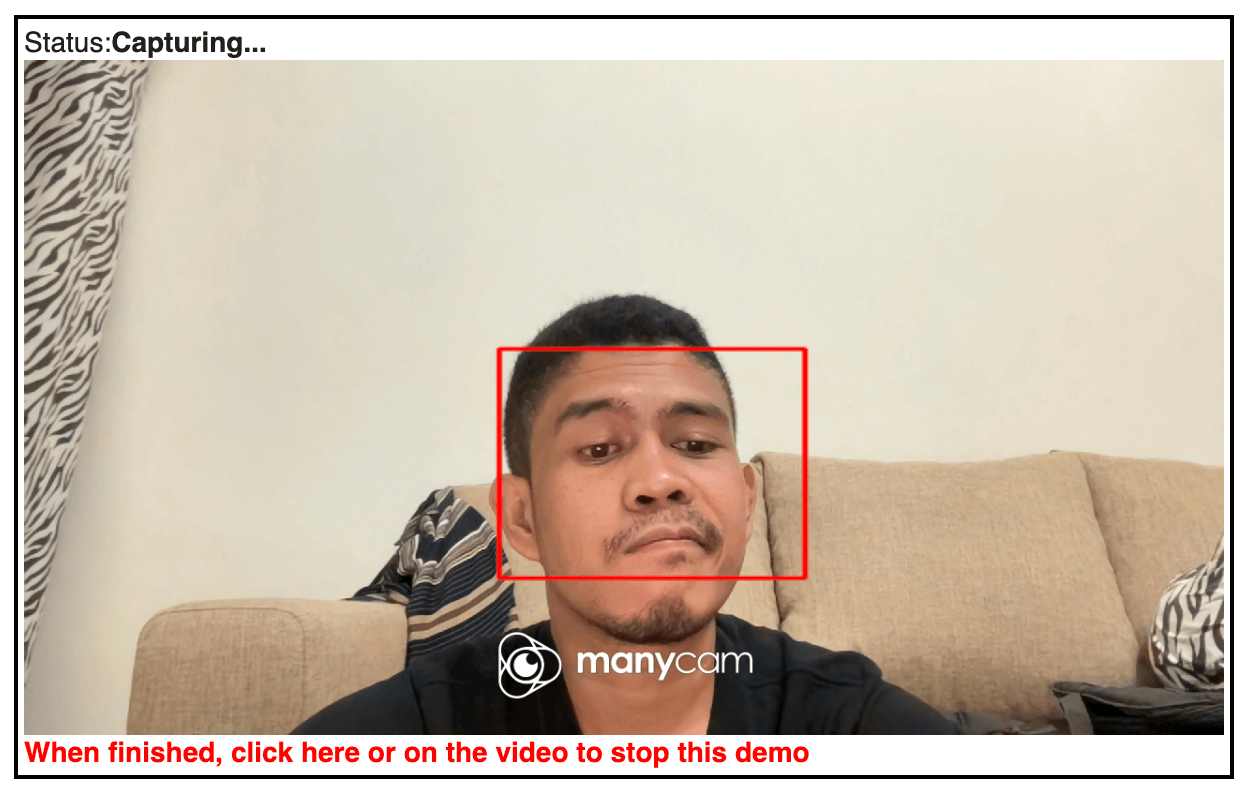